<a href="https://colab.research.google.com/github/BhattacharyaSumit/Open-CV-Tasks/blob/master/Bank_Check_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
from skimage.segmentation import clear_border
from imutils import contours
import numpy as np
import imutils
import cv2

In [0]:
def extract_digits_and_symbols(image, charCnts, minW=5, minH=15):
	
	charIter = charCnts.__iter__()
	rois = []
	locs = []

	
	while True:
		try:
			
			c = next(charIter)
			(cX, cY, cW, cH) = cv2.boundingRect(c)
			roi = None

			
			if cW >= minW and cH >= minH:
				# extracting the Region Of Interest
				roi = image[cY:cY + cH, cX:cX + cW]
				rois.append(roi)
				locs.append((cX, cY, cX + cW, cY + cH))

			
			else:
				
				parts = [c, next(charIter), next(charIter)]
				(sXA, sYA, sXB, sYB) = (np.inf, np.inf, -np.inf,
					-np.inf)

				# loop over the parts
				for p in parts:
					
					(pX, pY, pW, pH) = cv2.boundingRect(p)
					sXA = min(sXA, pX)
					sYA = min(sYA, pY)
					sXB = max(sXB, pX + pW)
					sYB = max(sYB, pY + pH)

				# extract the ROI
				roi = image[sYA:sYB, sXA:sXB]
				rois.append(roi)
				locs.append((sXA, sYA, sXB, sYB))

		
		except StopIteration:
			break

	# returning a tuple of the ROIs and locations
	return (rois, locs)




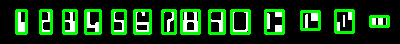

-1

In [0]:
# T = Transit (delimit bank branch routing transit #)
# U = On-us (delimit customer account number)
# A = Amount (delimit transaction amount)
# D = Dash (delimit parts of numbers, such as routing or account)
charNames = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0",
	"T", "U", "A", "D"]

ref = cv2.imread("/content/bank-check-ocr/micr_e13b_reference.png")
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = imutils.resize(ref, width=400)
ref = cv2.threshold(ref, 0, 255, cv2.THRESH_BINARY_INV |
	cv2.THRESH_OTSU)[1]

# finding contours in the MICR image and sort them from left to right
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
refCnts = refCnts[1] 
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]


(refROIs, refLocs) = extract_digits_and_symbols(ref, refCnts, 10, 20)
chars = {}

clone = np.dstack([ref.copy()] * 3)

# looping over the reference ROIs and locations
for (name, roi, loc) in zip(charNames, refROIs, refLocs):
	
	(xA, yA, xB, yB) = loc
	cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 255, 0), 2)

	roi = cv2.resize(roi, (36, 36)) 
	chars[name] = roi

cv2_imshow(clone)
cv2.waitKey(0)

In [0]:
refROIs = extract_digits_and_symbols(ref, refCnts, minW=10, minH=20)[0]
chars = {}
 
for (name, roi) in zip(charNames, refROIs):
	
	roi = cv2.resize(roi, (36, 36)) 
	chars[name] = roi
  
  
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 7))
output = []
 
# load the input image, grab its dimensions, and apply array slicing
# to keep only the bottom 20% of the image (that's where the account
# information is)
image = cv2.imread("/content/bank-check-ocr-2/example_check.png")
(h, w,) = image.shape[:2]
delta = int(h - (h * 0.2))
bottom = image[delta:h, 0:w]
gray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0,
	ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = clear_border(thresh)


In [0]:
groupCnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
groupCnts = imutils.grab_contours(groupCnts)
groupLocs = []
 
# loop over the group contours
for (i, c) in enumerate(groupCnts):
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
 
	
	if w > 50 and h > 15:
		groupLocs.append((x, y, w, h))
 

groupLocs = sorted(groupLocs, key=lambda x:x[0])

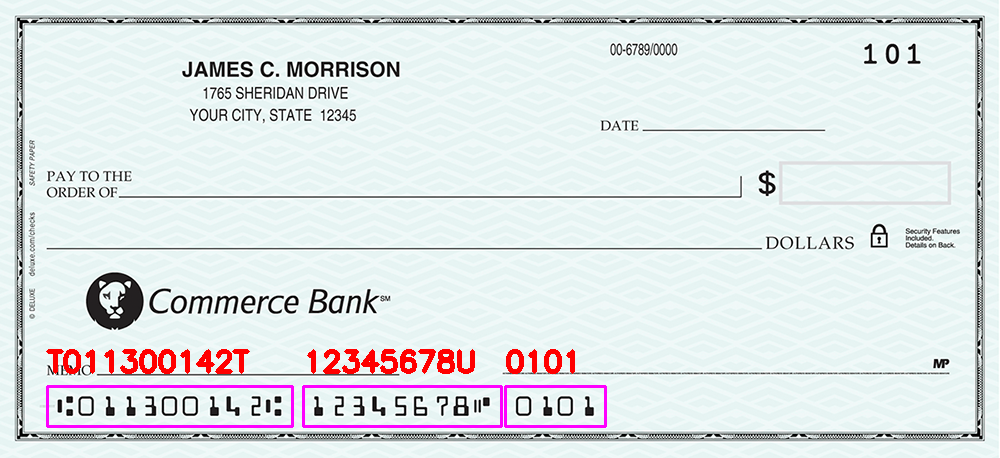

-1

In [0]:
for (gX, gY, gW, gH) in groupLocs:
	# initialize the group output of characters
	groupOutput = []

	
	group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
	group = cv2.threshold(group, 0, 255,
		cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

	
	charCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	charCnts = imutils.grab_contours(charCnts)
	charCnts = contours.sort_contours(charCnts,
		method="left-to-right")[0]

	
	(rois, locs) = extract_digits_and_symbols(group, charCnts)

	# loop over the ROIs from the group
	for roi in rois:
		
		scores = []
		roi = cv2.resize(roi, (36, 36))

		
		for charName in charNames:
			# apply correlation-based template matching, take the
			# score, and update the scores list
			result = cv2.matchTemplate(roi, chars[charName],
				cv2.TM_CCOEFF)
			(_, score, _, _) = cv2.minMaxLoc(result)
			scores.append(score)

		# the classification for the character ROI will be the
		# reference character name with the *largest* template
		# matching score
		groupOutput.append(charNames[np.argmax(scores)])

	# draw (padded) bounding box surrounding the group along with
	# the OCR output of the group
	cv2.rectangle(image, (gX - 10, gY + delta - 10),
		(gX + gW + 10, gY + gY + delta), (255, 0, 255), 2)
	cv2.putText(image, "".join(groupOutput),
		(gX - 10, gY + delta - 25), cv2.FONT_HERSHEY_SIMPLEX,
		0.95, (0, 0, 255), 3)

	# add the group output to the overall check OCR output
	output.append("".join(groupOutput))

# display the output check OCR information to the screen
cv2_imshow(image)
cv2.waitKey(0)